In [1]:
%reset-f
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("always",category=UserWarning)
from res_ind_lib import *
import os, time
import itertools

from progress_reporter import *

In [2]:
#Folder where outputs are stored
out_folder = "scorecards/"
os.makedirs(out_folder,exist_ok=True)

In [3]:
pd.set_option('mode.use_inf_as_null', True)

# data

In [4]:
df_original=pd.read_csv("df_original.csv",index_col="Province")

#appends "countries" from the sensitivity analysis
df_original=df_original.append(pd.read_csv("df_sensit_input.csv",index_col="Province"))

df_with_results=pd.read_csv("df.csv",index_col="Province")

#Rankings 
ranks = df_with_results.dropna(how="all",axis=1).dropna().rank(method="min",ascending =False) 
ranks.to_csv("rankings.csv")

#appends sensitivity anlysis
df_with_results=df_with_results.append(pd.read_csv("df_sensit_results.csv").set_index("Province"))

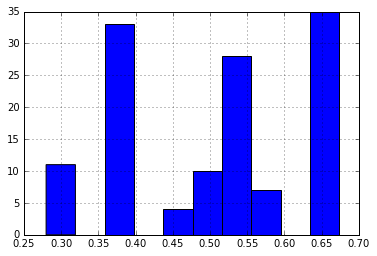

In [5]:
df_original.shew.hist()

In [6]:
df_original["rel_gdp_pp"] = df_original["gdp_pc_pp"]/df_original["gdp_pc_pp_nat"]
df_original["scale_up_target"] = .5
df_original["pov_head_ref"] = df_original["pov_head"]

In [7]:
df_with_results.columns.values;


# computes all derivatives

In [8]:
def compute_derivative(df_original,deriv_set,score_card_set):
    der = pd.DataFrame(index=df_original.index, columns=pd.MultiIndex.from_product([deriv_set,score_card_set], names=['inputs', 'outputs']))
    h=0.0001
    #loop on all data in df prior to add the results
    fx = compute_resiliences(df_original)[score_card_set]
    for var in deriv_set:
        progress_reporter(var)
        try:
            df_=df_original.copy(deep=True)
            df_[var]=df_[var]+h
            fxh= compute_resiliences(df_)[score_card_set]
            der[var] = (fxh-fx)/(h)
        except TypeError:
            print("no derivative for " +var)
    return der.swaplevel('inputs', 'outputs', axis=1).sort_index(axis=1)

In [9]:
deriv_set = np.setdiff1d( df_original.columns.values,
    ["pop","iso3","original_country","gdp_pc_pp","gdp_pc_pp_ref","gdp_pc_pp_nat","avg_prod_k_ref",
     "income_elast","faref","avg_prod_k", "peref","vref","share1_ref","share1",
     'pov_head_ref',"bashs","ophe","fa_ref","v_ref","scale_up_target","rating","finance_pre","borrow_abi","prepare_scaleup"]+[c for c in df_original.columns if c.startswith("fa_ratio")])

pd.DataFrame(data=deriv_set).to_csv("deriv_set.csv",index=False,header=False)

score_card_set = ["resilience", "resilience_no_shock", "resilience_no_shock_no_uspcale", "resilience_no_shock_no_SP","v_shew","risk"]
                  #"delta_W","dWsurWprime", "equivalent_cost", "dW_destitution", "total_equivalent_cost_no_destitution" ]

#Checks that info has information for all variables in deriv_set
info = pd.read_csv("inputs_info.csv").set_index("key")
for d in deriv_set:
    if d not in info.index.values:
        raise Exception(d+" is not documented in inputs_info.csv")

        
deriv_set

array(['H', 'T_rebuild_K', 'T_rebuild_L', 'alpha', 'axfin_p', 'axfin_r',
       'axhealth', 'fa', 'nat_buyout', 'pe', 'pi', 'plgp', 'pov_head',
       'protection', 'pv', 'rel_gdp_pp', 'shew', 'sigma_p', 'sigma_r',
       'social_p', 'social_r', 'unemp', 'v', 'v_s'], dtype=object)

In [10]:
ders = compute_derivative(df_original,deriv_set,score_card_set)

v_s


In [11]:
derivatives=ders
"""
#computes all derivatives
for outname in score_card_set:
    derivatives[outname]=(derivatives[outname]/info["weight_der"]).fillna() #weights derivatives by number of people affected [avoids creating new clumns with nans]
""";

# output

In [12]:
#computes derivative of risk wrt resilience
der_risk = derivatives["risk"].copy()
der_risk["resilience"]=(derivatives.risk/derivatives.resilience).mode(axis=1).mean(axis=1) #because of floating point operations, mode can return several close values


der_vshew = derivatives["v_shew"]
der_risk["v_shew"]=(der_risk.v/ (der_vshew.v)) 

derivatives["resilience"].to_csv("deriv.csv")
der_risk.to_csv("deriv_risk.csv")

output signs in excel

In [13]:
#saves derivatives in excel tabs with signs in colors (very usefull for understanding the model)
writer= pd.ExcelWriter("signs.xlsx", engine='xlsxwriter')
workbook=writer.book
# Add a format. Light red fill with dark red text.
red = workbook.add_format({'bg_color': '#FFC7CE',
                               'font_color': '#9C0006'})

blue = workbook.add_format({'bg_color': '#92c5de',
                               'font_color': '#000061'})
for outname in score_card_set:
    sheetname = outname[0:30]
    #for outname in ["resilience"]:
    (derivatives[outname].dropna()).to_excel(writer,sheet_name=sheetname)
    writer.sheets[sheetname].conditional_format('B2:BB600', {'type':'cell',
                                    'criteria': '>',
                                    'value':    0,
                                    'format':   blue})
    writer.sheets[sheetname].conditional_format('B2:BB600', {'type':'cell',
                                    'criteria': '<',
                                    'value':    0,
                                    'format':   red})
    writer.sheets[sheetname].freeze_panes(1, 1)


In [14]:
try :
    writer.save()
except PermissionError:
    warnings.warn("Cannot write excel file. Check that it's not opened and try again")


In [15]:
#Signs of resilience derivative 
der =     np.sign(derivatives["resilience"]).replace(0,np.nan)
signs= pd.Series(index=der.columns)
for i in signs.index:
    if (der[i].min()==der[i].max()): #all nonnan signs are equal
        signs[i]=der[i].min()
    else:
        print("ambigous sign for "+i)
        signs[i]=np.nan



ambigous sign for T_rebuild_K
ambigous sign for pe
ambigous sign for pov_head
ambigous sign for protection


# Write Excel scorecards

In [16]:
if True:
    abs_derivative = signs*derivatives["resilience"] #abs value
    step_for_one = (0.01/abs_derivative).replace([-np.inf,np.inf],[np.nan,np.nan])


    headr = list(itertools.product(derivatives.dropna().index.values,['level', "ranking",'der','for_one']))
    scores=  pd.DataFrame(index=deriv_set, columns=pd.MultiIndex.from_tuples(headr))


    for c in derivatives.dropna().index:
        scores[(c,'level')]=df_original.ix[c]
        scores[(c,'der')]=abs_derivative.ix[c]
        scores[(c,'for_one')]=step_for_one.ix[c]
        scores[(c,'ranking')]=ranks.ix[df_original.ix[c,"original_country"]]


    for c in derivatives.dropna().index:
    #for c in ["France"]:
        with pd.ExcelWriter('scorecards/'+c.lower().replace(" ","_").replace("\\","")+'.xlsx', engine='xlsxwriter') as writer:
            percent = writer.book.add_format()
            percent.set_num_format("0.0%")

            outs = df_with_results.ix[df_with_results.index==c,score_card_set]
            outs.transpose().to_excel(writer)
            scores[c].reset_index().rename(columns={"index":"input"}).to_excel(writer,startrow =2+len(score_card_set),index=False)
